# 0. Library

In [1]:
# --- Core Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import time
import warnings
import pickle
import os

# --- Sklearn ---
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (roc_auc_score, roc_curve, precision_recall_curve, auc,
                             accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, brier_score_loss, log_loss, classification_report)
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold

# --- TabNet & PyTorch ---
import torch
from pytorch_tabnet.tab_model import TabNetClassifier

# 1. Utility functions + Configurations

## 1.1 Utility functions

In [2]:
# --- Helper Functions (can be imported from a utils file or redefined) ---
def calculate_ks(y_true, y_prob):
    """Calculates the Kolmogorov-Smirnov (KS) statistic."""
    df = pd.DataFrame({'y_true': y_true, 'y_prob': y_prob})
    df = df.sort_values(by='y_prob', ascending=False)
    # Ensure y_true sums are not zero before division
    sum_true = df['y_true'].sum()
    sum_false = len(df) - sum_true
    if sum_true == 0 or sum_false == 0:
        return 0.0 # KS is 0 if one class is missing
    df['cumulative_true'] = df['y_true'].cumsum() / sum_true
    df['cumulative_false'] = (1 - df['y_true']).cumsum() / sum_false
    ks = max(abs(df['cumulative_true'] - df['cumulative_false']))
    return ks

def find_optimal_threshold_j_statistic(y_true, y_prob_oof):
    """Finds the optimal threshold maximizing Youden's J statistic (Sensitivity + Specificity - 1)."""
    fpr, tpr, thresholds = roc_curve(y_true, y_prob_oof)
     # Handle cases where thresholds might not be strictly decreasing
    valid_indices = np.where(np.isfinite(thresholds))[0]
    if len(valid_indices) == 0:
        print("Warning: No valid thresholds found for J-statistic calculation.")
        return 0.5 # Default fallback
    fpr, tpr, thresholds = fpr[valid_indices], tpr[valid_indices], thresholds[valid_indices]

    if len(thresholds) == 0:
         print("Warning: Threshold array is empty after filtering.")
         return 0.5

    j_statistic = tpr - fpr
    optimal_idx = np.argmax(j_statistic)
    optimal_threshold = thresholds[optimal_idx]
    # Ensure threshold is within [0, 1] bounds if necessary due to floating point issues
    optimal_threshold = max(0.0, min(1.0, optimal_threshold))
    print(f"Optimal threshold based on Youden's J-Statistic (OOF): {optimal_threshold:.4f}")
    return optimal_threshold

def evaluate_model(y_true, y_pred_proba, y_pred_binary, model_name="Model"):
    """Calculates and prints standard classification metrics."""
    # Add epsilon to probabilities for log_loss if necessary
    eps = 1e-15
    y_pred_proba = np.clip(y_pred_proba, eps, 1 - eps)

    auc_roc = roc_auc_score(y_true, y_pred_proba)
    gini = 2 * auc_roc - 1
    ks = calculate_ks(y_true, y_pred_proba)
    accuracy = accuracy_score(y_true, y_pred_binary)
    precision = precision_score(y_true, y_pred_binary, zero_division=0)
    recall = recall_score(y_true, y_pred_binary, zero_division=0)
    f1 = f1_score(y_true, y_pred_binary, zero_division=0)
    brier = brier_score_loss(y_true, y_pred_proba)
    logloss = log_loss(y_true, y_pred_proba)
    cm = confusion_matrix(y_true, y_pred_binary)

    print(f"\n--- Evaluation Metrics for {model_name} ---")
    print(f"AUC ROC:        {auc_roc:.4f}")
    print(f"Gini Coefficient: {gini:.4f}")
    print(f"KS Statistic:   {ks:.4f}")
    print(f"Accuracy:       {accuracy:.4f}")
    print(f"Precision:      {precision:.4f}")
    print(f"Recall (TPR):   {recall:.4f}")
    print(f"F1-Score:       {f1:.4f}")
    print(f"Brier Score:    {brier:.4f}")
    print(f"Log Loss:       {logloss:.4f}")
    print("\nConfusion Matrix:")
    print(cm)

    results = {
        'Model': model_name,
        'AUC': auc_roc, 'Gini': gini, 'KS': ks, 'Accuracy': accuracy,
        'Precision': precision, 'Recall': recall, 'F1': f1,
        'Brier': brier, 'LogLoss': logloss
    }
    return results

def plot_roc_curve(y_true, y_prob, model_name):
    """Plots the ROC curve."""
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc_roc = roc_auc_score(y_true, y_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_roc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--') # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} - ROC Curve')
    plt.legend()
    plt.grid(True)
    # Save the plot
    plot_filename = f"roc_curve_{model_name.replace(' ', '_')}.png"
    plt.savefig(plot_filename)
    print(f"ROC curve saved to {plot_filename}")
    plt.show()

## 1.2 Configurations

In [3]:
# --- Configuration ---
DATA_PATH = '../data/processed/'
MODEL_OUTPUT_PATH = './tabnet_outputs/' # Directory to save model/results
os.makedirs(MODEL_OUTPUT_PATH, exist_ok=True)
SEED = 42
N_SPLITS = 5
TARGET = 'TARGET'
ID_COL = 'SK_ID_CURR'

# --- Check for GPU ---
device_name = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device_name}")

Using device: cuda


# 2. Load Data and Preprocess

In [4]:
# --- Load Data ---
print("Loading preprocessed data...")
try:
    train_df = pd.read_csv(DATA_PATH + 'train.csv')
    test_df = pd.read_csv(DATA_PATH + 'test.csv')
    print("Data loaded successfully.")
except FileNotFoundError as e:
    print(f"Error: {e}. Make sure 'train_final.csv' and 'test_final.csv' are in {DATA_PATH}")
    exit()

# --- Prepare Data ---
y_train = train_df[TARGET].values # Use .values for numpy arrays
y_test = test_df[TARGET].values

# Drop Target and potentially ID
if ID_COL in train_df.columns:
    X_train = train_df.drop(columns=[TARGET, ID_COL])
    X_test = test_df.drop(columns=[TARGET, ID_COL])
else:
    X_train = train_df.drop(columns=[TARGET])
    X_test = test_df.drop(columns=[TARGET])

# Align columns just in case
common_cols = list(X_train.columns.intersection(X_test.columns))
X_train = X_train[common_cols]
X_test = X_test[common_cols]
feature_names = X_train.columns.tolist()

Loading preprocessed data...
Data loaded successfully.


In [5]:
# # --- Feature Selection: Low Variance Filter ---
# print("\nApplying Low Variance Feature Selection...")
# var_selector = VarianceThreshold(threshold=0.01)

# # Fit on training data only
# var_selector.fit(X_train)

# # Get the boolean mask of selected features
# feature_mask = var_selector.get_support()
# original_feature_names = X_train.columns.tolist() # Get original names before transformation
# selected_feature_names = [name for name, selected in zip(original_feature_names, feature_mask) if selected]

# print(f"Original number of features: {X_train.shape[1]}")
# print(f"Number of features after variance thresholding: {len(selected_feature_names)}")

# # Transform both X_train and X_test
# X_train_np_selected = var_selector.transform(X_train)
# X_test_np_selected = var_selector.transform(X_test)

# # Convert back to DataFrame with selected column names
# X_train = pd.DataFrame(X_train_np_selected, columns=selected_feature_names, index=X_train.index)
# X_test = pd.DataFrame(X_test_np_selected, columns=selected_feature_names, index=X_test.index)

# # Update the global feature_names list
# feature_names = selected_feature_names

# print(f"Updated X_train shape: {X_train.shape}")
# print(f"Updated X_test shape: {X_test.shape}")

In [6]:
# --- LIMITATION: Treat all features as numerical ---
# Ideally, identify original categorical features and pass their indices to TabNet.
# Since we are using pre-encoded data, we treat all as numerical.
print("WARNING: Treating all features as numerical for TabNet due to pre-encoded input data.")
categorical_indices = [] # No categorical indices provided
categorical_dims = [] # No specific dimensions needed if indices are empty

# Handle infinite values and NaNs
# Replace inf with NaN, then fill NaN with median of each column
X_train = X_train.replace([np.inf, -np.inf], np.nan).fillna(X_train.median())
X_test = X_test.replace([np.inf, -np.inf], np.nan).fillna(X_train.median()) # Use train median for test set

# Standardize the data
# Note: TabNet can handle raw data, but standardization may help in some cases.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to numpy arrays of type float32 for PyTorch
X_train_np = X_train.astype(np.float32)
X_test_np = X_test.astype(np.float32)

print(f"Prepared X_train shape: {X_train_np.shape}")
print(f"Prepared X_test shape: {X_test_np.shape}")

Prepared X_train shape: (246005, 112)
Prepared X_test shape: (61502, 112)


# 3. Train and Evaluate

## 3.1 Train Baseline Model

In [7]:
# Calculate class weights inversely proportional to class frequencies
class_counts = np.bincount(y_train)
total_samples = len(y_train)
# More aggressive weighting for minority class
class_weights = torch.tensor([1.0, (class_counts[0]/class_counts[1]) * 1.0], dtype=torch.float32)
if device_name == 'cuda':
    class_weights = class_weights.cuda()

print(f"Using class weights: {class_weights.cpu().numpy()} to emphasize minority class")

# Create weighted loss function
weighted_loss = torch.nn.CrossEntropyLoss(weight=class_weights)

Using class weights: [ 1.       11.386959] to emphasize minority class


c:\Users\ORLab\main_source\CreditRiskProject\venv\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


TabNet model initialized on cuda
Fitting TabNet model...
epoch 0  | loss: 2.69472 | validation_logloss: 1.28078 | validation_accuracy: 0.66887 | validation_auc: 0.51533 | validation_balanced_accuracy: 0.50883 |  0:00:13s
epoch 1  | loss: 1.60854 | validation_logloss: 2.31986 | validation_accuracy: 0.41229 | validation_auc: 0.56637 | validation_balanced_accuracy: 0.55208 |  0:00:26s
epoch 2  | loss: 1.39195 | validation_logloss: 0.54486 | validation_accuracy: 0.73517 | validation_auc: 0.59314 | validation_balanced_accuracy: 0.56131 |  0:00:39s
epoch 3  | loss: 0.7307  | validation_logloss: 0.82564 | validation_accuracy: 0.46586 | validation_auc: 0.6582  | validation_balanced_accuracy: 0.60545 |  0:00:51s
epoch 4  | loss: 0.67029 | validation_logloss: 0.63509 | validation_accuracy: 0.66759 | validation_auc: 0.67909 | validation_balanced_accuracy: 0.62388 |  0:01:04s
epoch 5  | loss: 0.63055 | validation_logloss: 0.67909 | validation_accuracy: 0.60196 | validation_auc: 0.71495 | validatio

c:\Users\ORLab\main_source\CreditRiskProject\venv\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Baseline model training completed in 2288.35 seconds.

--- TabNet Model Evaluation ---

--- Evaluation Metrics for TabNet ---
AUC ROC:        0.7537
Gini Coefficient: 0.5075
KS Statistic:   0.3751
Accuracy:       0.7112
Precision:      0.1690
Recall (TPR):   0.6580
F1-Score:       0.2689
Brier Score:    0.1895
Log Loss:       0.5601

Confusion Matrix:
[[40473 16064]
 [ 1698  3267]]
ROC curve saved to roc_curve_TabNet.png


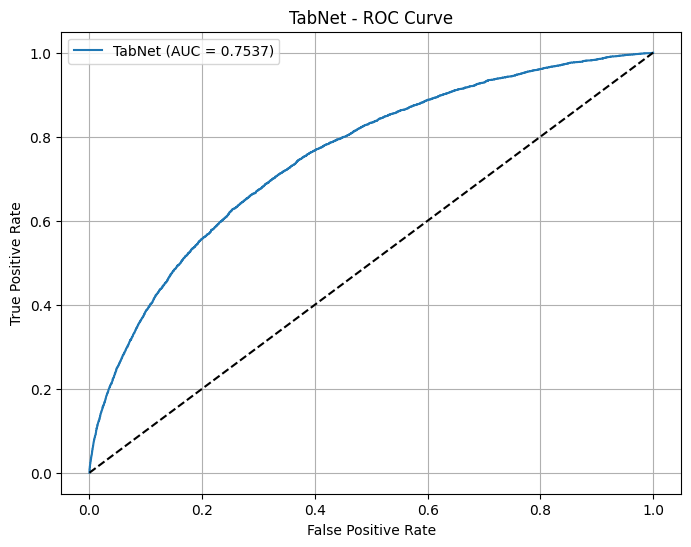

In [8]:
# TabNet Specific Config
TABNET_PARAMS = dict(
    # Network architecture
    n_d=128,             
    n_a=128,              
    n_steps=10,          
    n_independent=6,    
    n_shared=6,     
    
    # Regularization
    gamma=1.7,         
    lambda_sparse=5e-4, 
    
    # Optimizer settings
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=1e-2),
    
    # Learning rate scheduler
    scheduler_params=dict(
        mode="max", 
        patience=50,    
        min_lr=1e-4, 
        factor=0.5
    ),
    scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
    
    mask_type='sparsemax',
    verbose=1,
    seed=42 
)

# Training Config
MAX_EPOCHS = 1000
PATIENCE = 50
BATCH_SIZE = 4096
VIRTUAL_BATCH_SIZE = 1024

X_train_base, X_val_base, y_train_base, y_val_base = train_test_split(
    X_train_np, y_train, test_size=0.2, random_state=SEED, stratify=y_train
)

tabnet = TabNetClassifier(**TABNET_PARAMS)
print(f"TabNet model initialized on {device_name}")
print("Fitting TabNet model...")
start_time = time.time()

tabnet.fit(
    X_train=X_train_base, y_train=y_train_base,
    eval_set=[(X_val_base, y_val_base)],
    eval_name=['validation'],
    eval_metric=['logloss' , 'accuracy', 'auc', 'balanced_accuracy'],
    max_epochs=MAX_EPOCHS,
    patience=PATIENCE,
    batch_size=BATCH_SIZE,
    virtual_batch_size=VIRTUAL_BATCH_SIZE,
    drop_last=False,
    loss_fn=weighted_loss,
    num_workers=0,
)

end_time = time.time()
print(f"Baseline model training completed in {(end_time - start_time):.2f} seconds.")

baseline_preds = tabnet.predict_proba(X_test_np)[:, 1]
baseline_binary_preds = (baseline_preds > 0.5).astype(int)

print("\n--- TabNet Model Evaluation ---")
baseline_results = evaluate_model(
    y_test, baseline_preds, baseline_binary_preds, model_name="TabNet"
)

plot_roc_curve(y_test, baseline_preds, "TabNet")

baseline_results_df = pd.DataFrame([baseline_results])
baseline_results_filename = os.path.join(MODEL_OUTPUT_PATH, "tabnet_results.csv")
baseline_results_df.to_csv(baseline_results_filename, index=False, mode='w+')

baseline_importance = tabnet.feature_importances_
baseline_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': baseline_importance})
baseline_importance_df = baseline_importance_df.sort_values(by='Importance', ascending=False)
baseline_importance_filename = os.path.join(MODEL_OUTPUT_PATH, "tabnet_feature_importance.csv")
baseline_importance_df.to_csv(baseline_importance_filename, index=False, mode='w+')

In [9]:
# Get the optimal threshold using the validation set
optimal_threshold = find_optimal_threshold_j_statistic(y_val_base, tabnet.predict_proba(X_val_base)[:, 1])
print(f"Optimal threshold for validation set: {optimal_threshold:.4f}")

baseline_binary_preds_optimal = (baseline_preds > optimal_threshold).astype(int)

print("\n--- Baseline TabNet Model Evaluation with Optimal Threshold ---")

baseline_results_optimal = evaluate_model(
    y_test, baseline_preds, baseline_binary_preds_optimal, model_name="TabNet (Baseline with Optimal Threshold)"
)

baseline_results_optimal_df = pd.DataFrame([baseline_results_optimal])
baseline_results_optimal_filename = os.path.join(MODEL_OUTPUT_PATH, "tabnet_results_optimal.csv")
baseline_results_optimal_df.to_csv(baseline_results_optimal_filename, index=False, mode='w+')
print(f"Baseline results with optimal threshold saved to {baseline_results_optimal_filename}")

Optimal threshold based on Youden's J-Statistic (OOF): 0.4915
Optimal threshold for validation set: 0.4915

--- Baseline TabNet Model Evaluation with Optimal Threshold ---

--- Evaluation Metrics for TabNet (Baseline with Optimal Threshold) ---
AUC ROC:        0.7537
Gini Coefficient: 0.5075
KS Statistic:   0.3751
Accuracy:       0.7020
Precision:      0.1659
Recall (TPR):   0.6683
F1-Score:       0.2659
Brier Score:    0.1895
Log Loss:       0.5601

Confusion Matrix:
[[39859 16678]
 [ 1647  3318]]
Baseline results with optimal threshold saved to ./tabnet_outputs/tabnet_results_optimal.csv


In [ ]:
# Save the model
model_filename = os.path.join(MODEL_OUTPUT_PATH, "tabnet_model.pkl")
with open(model_filename, 'wb') as f:
    pickle.dump(tabnet, f)
print(f"TabNet model saved to {model_filename}")

In [10]:
# --- Explainability: Feature Importance per Decision Step ---
print("\n--- Feature Importance based on Individual Decision Step Masks ---")

# Explain the test set predictions to get the aggregate mask and per-step masks
# explain() returns:
# 1. Aggregate mask across all steps (M_explain)
# 2. Dictionary of masks per step {step_index: mask_array}
try:
    aggregate_masks, step_masks = tabnet.explain(X_test_np)
    print(f"Shape of aggregate mask returned by explain(): {aggregate_masks.shape}") # (n_samples, n_features)
    print(f"Number of decision steps with masks: {len(step_masks)}")

    # --- Aggregate Mask Importance (as before, for comparison) ---
    aggregate_mask_importance = np.mean(aggregate_masks, axis=0) # Shape: (n_features,)
    mask_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance_Aggregate_Mask': aggregate_mask_importance
    })
    mask_importance_df = mask_importance_df.sort_values(by='Importance_Aggregate_Mask', ascending=False)
    print(f"\nTop 10 Features based on Aggregate Mask Importance:")
    print(mask_importance_df.head(10))
    # Optionally save this aggregate mask's importance
    mask_importance_filename = os.path.join(MODEL_OUTPUT_PATH, "tabnet_feature_importance_aggregate_mask.csv")
    mask_importance_df.to_csv(mask_importance_filename, index=False)
    print(f"Importance based on aggregate mask saved to {mask_importance_filename}")


    # --- Per-Step Mask Importance ---
    all_step_importances = {}
    print("\n--- Feature Importance per Decision Step ---")
    for step_index, step_mask_array in step_masks.items():
        # step_mask_array shape: (n_samples, n_features)
        # Calculate importance for this step by averaging the mask across samples
        step_importance = np.mean(step_mask_array, axis=0) # Shape: (n_features,)

        step_importance_df = pd.DataFrame({
            'Feature': feature_names,
            f'Importance_Step_{step_index}': step_importance
        })
        step_importance_df = step_importance_df.sort_values(by=f'Importance_Step_{step_index}', ascending=False)

        all_step_importances[step_index] = step_importance_df

        print(f"\nTop 10 Features for Step {step_index}:")
        print(step_importance_df.head(10))

        # Optionally save importance for each step
        step_importance_filename = os.path.join(MODEL_OUTPUT_PATH, f"tabnet_feature_importance_step_{step_index}.csv")
        step_importance_df.to_csv(step_importance_filename, index=False)
        print(f"Importance for step {step_index} saved to {step_importance_filename}")

except AttributeError:
     print("Could not find attribute 'explain' on the model. Ensure the model object is a trained TabNetClassifier.")
except Exception as e:
    print(f"An error occurred during explanation: {e}")
    # If explain() fails or returns unexpected format, print error.



--- Feature Importance based on Individual Decision Step Masks ---
Shape of aggregate mask returned by explain(): (61502, 112)
Number of decision steps with masks: 10

Top 10 Features based on Aggregate Mask Importance:
                                               Feature  \
0                                  WEIGHTED_EXT_SOURCE   
84                                   AGE_EMPLOYED_DIFF   
86   AMT_INCOME_TOTAL_MAX_AGG_CODE_GENDER_NAME_FAMI...   
92                             HOUR_PROCESS_CREDIT_MUL   
5                                         EXT_SOURCE_1   
87                                   CREDIT_GOODS_DIFF   
32   AMT_ANNUITY_MEAN_AGG_NAME_CONTRACT_TYPE_NAME_I...   
49   AGE_EMPLOYED_DIFF_MIN_AGG_FLAG_OWN_CAR_FLAG_OW...   
106                                        AMT_ANNUITY   
98                                 APARTMENTS_SUM_MODE   

     Importance_Aggregate_Mask  
0                     1.760804  
84                    0.449093  
86                    0.361354  
92      